In [1]:
def f(x):
    return x * x + 3*x - 2

In [2]:
xs = range(-5, 6)
ys = [f(x) for x in xs]
# TODO: dodati noise

In [3]:
from matplotlib import pyplot as plt

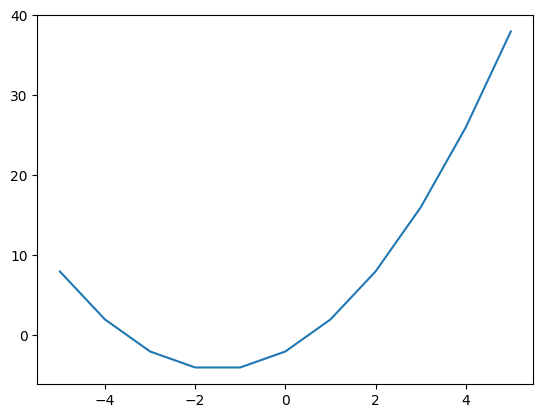

In [4]:
plt.plot(xs, ys)

In [5]:
from abc import ABC, abstractmethod
from copy import deepcopy
import random

In [6]:
class Node(ABC):
    @abstractmethod
    def evaluate(self, x: int):
        pass

    @abstractmethod
    def __str__(self):
        pass

    @staticmethod
    @abstractmethod
    def generate_random_tree(depth: int):
        pass

    @abstractmethod
    def get_random_subtree(self, is_root: bool):
        pass

    @abstractmethod
    def swap_subtrees(self, curr_subtree, new_subtree):
        pass

In [7]:
class Terminal(Node):
    def __init__(self, value: int | None = None):
        self.value = value

    def evaluate(self, x: int):
        if self.value is not None:
            return self.value
        return x

    def generate_random_tree(depth: int) -> Node:
        assert depth == 1
        if random.random() < 0.5:
            return Terminal()
        else:
            return Terminal(value=random.randrange(-5, 6))
        
    def get_random_subtree(self, is_root: bool) -> Node:
        return self
    
    def swap_subtrees(self, curr_subtree: Node, new_subtree: Node) -> Node:
        if self == curr_subtree:
            return new_subtree
        else:
            return self

    def __str__(self):
        if self.value is not None:
            return f"{self.value}"
        return "x"


In [8]:
class Operator(Node):
    ALLOWED_OPS = '+-*'

    def __init__(self, op: str, left: Node, right: Node):
        self.op = op
        self.left = left
        self.right = right

    def evaluate(self, x: int):
        left = self.left.evaluate(x)
        right = self.right.evaluate(x)
        match self.op:
            case '+':
                return left + right
            case '-':
                return left - right
            case '*':
                return left * right
            case _:
                raise ValueError(f"unknown op: {self.op}")
            # za domaci: implementirati / - obratiti paznju na deljenje nulom

    def generate_random_tree(depth: int) -> Node:
        if depth == 1:
            return Terminal.generate_random_tree(depth=1)
        
        left = Operator.generate_random_tree(depth - 1)
        right = Operator.generate_random_tree(depth - 1)
        op = random.choice(Operator.ALLOWED_OPS)

        return Operator(op=op, left=left, right=right)

    def get_random_subtree(self, is_root: bool):
        r = random.random()
        if is_root:
            if r < 1 / 2:
                return self.left.get_random_subtree(is_root=False)
            else:
                return self.right.get_random_subtree(is_root=False)

        # TODO razmisliti o raspodeli
        if r < 1 / 2:
            return self
        elif r < 3 / 4:
            return self.left.get_random_subtree(is_root=False)
        else:
            return self.right.get_random_subtree(is_root=False)
        
    def swap_subtrees(self, curr_subtree, new_subtree) -> Node:
        if self == curr_subtree:
            return new_subtree
        
        left = self.left.swap_subtrees(curr_subtree, new_subtree)
        right = self.right.swap_subtrees(curr_subtree, new_subtree)
        return Operator(op=self.op, left=left, right=right)

    def __str__(self):
        return f"({self.left} {self.op} {self.right})"

In [9]:
x = Operator.generate_random_tree(depth=3)

In [10]:
str(x)

'((x - x) + (x * 3))'

In [11]:
s = x.get_random_subtree(is_root=True)
str(s)

'(x * 3)'

In [12]:
new_s = Operator('+', left=Terminal(2), right=Terminal())
new_x = x.swap_subtrees(s, new_s)
str(new_x)

'((x - x) + (2 + x))'

In [13]:
class Individual:
    def __init__(self, xs: list[int], ys: list[int], depth: int | None = None, code: Node | None = None):
        if code is not None:
            self.code = code
        else:
            assert depth is not None
            self.code = Operator.generate_random_tree(depth=depth)
            # print(self.code)
        self.fitness = self.calc_fitness(xs, ys)

    def calc_fitness(self, xs, ys):
        mse = 0
        for x, y in zip(xs, ys):
            y_pred = self.code.evaluate(x)
            mse += (y_pred - y) ** 2
        return -mse
    
    def __lt__(self, other):
        return self.fitness < other.fitness

In [17]:
class GeneticProgramming:
    def __init__(
            self,
            xs: list[int],
            ys: list[int],
            max_init_depth: int,
            population_size: int,
            num_generations: int,
            mutation_prob: float,
            elitism_size: float,
            crossover_type: str,
            selection_type: str,
            tournament_size: int | None,
        ):
        self.xs = xs
        self.ys = ys
        self.max_init_depth = max_init_depth

        self.population_size = population_size
        self.num_elite = int(population_size * elitism_size)
        if self.num_elite % 2 != self.population_size % 2:
            self.num_elite += 1
        self.mutation_prob = mutation_prob
        self.selection_type = selection_type
        if selection_type == 'tournament':
            assert tournament_size is not None
        self.tournament_size = tournament_size
        self.num_generations = num_generations
        self.crossover_type = crossover_type

    def selection(self, population: list[Individual]):
        match self.selection_type:
            case 'tournament':
                participants = random.sample(population, self.tournament_size)
                return max(participants)
            case 'roulette':
                # za domaci
                pass
            case 'rang':
                # za domaci
                pass
            case _:
                raise ValueError(f'unknown selection_type: {self.selection_type}')

    def crossover(self, parent1_code: Node, parent2_code: Node) -> tuple[Node, Node]:
        p1_subtree = parent1_code.get_random_subtree(is_root=True)
        p2_subtree = parent2_code.get_random_subtree(is_root=True)
        
        child1_code = deepcopy(parent1_code)
        child1_code = child1_code.swap_subtrees(p1_subtree, p2_subtree)

        child2_code = deepcopy(parent2_code)
        child2_code = child2_code.swap_subtrees(p2_subtree, p1_subtree)

        return child1_code, child2_code

    def mutation(self, ind_code: Node) -> Node:
        if random.random() < self.mutation_prob:
            if random.random() < 0.5:
                curr_subtree = ind_code.get_random_subtree(is_root=True)

                new_subtree = Operator.generate_random_tree(depth=random.randrange(1, 4))

                ind_code = ind_code.swap_subtrees(curr_subtree, new_subtree)
            else:
                op = random.choice(Operator.ALLOWED_OPS)
                ind_code = Operator(op, left=ind_code, right=Terminal(random.randrange(-5, 6)))

        return ind_code

    def solve(self) -> Individual:
        population = [Individual(xs=xs, ys=ys, depth=random.randrange(1, self.max_init_depth + 1)) for _ in range(self.population_size)]
        print(set(x.fitness for x in population))
        print(set(str(x.code) for x in population))
            
        best_fitnesses = []
        for _ in range(self.num_generations):
            population.sort(reverse=True)
            new_population = population[:self.num_elite]
            
            for i in range(self.num_elite, self.population_size, 2):
                parent1 = self.selection(population)
                parent2 = self.selection(population)

                child1_code, child2_code = self.crossover(parent1.code, parent2.code)

                child1_code = self.mutation(child1_code)
                child2_code = self.mutation(child2_code)

                child1 = Individual(xs, ys, code=child1_code)
                child2 = Individual(xs, ys, code=child2_code)
                
                new_population.append(child1)
                new_population.append(child2)

            population = deepcopy(new_population)
            print(sorted(set(x.fitness for x in population), reverse=True))
            print(set(str(x.code) for x in population))
            print(len(population))
            best_fitnesses.append(max(population).fitness)

        plt.plot(best_fitnesses)
        return max(population)

In [18]:
gp = GeneticProgramming(xs=xs, ys=ys, max_init_depth=4, population_size=200, num_generations=100, mutation_prob=0.07, elitism_size=0.07, selection_type='tournament', tournament_size=10, crossover_type='')

{-25597, -2552, -13816, -19448, -706024, -2024, -7139, -91091, -2002, -1474, -653752, -3509, -15796, -1958, -4004, -5027, -1947, -8602, -5522, -10637, -8074, -30602, -117128, -17798, -48004, -2948, -385, -12941180, -1397, -3949, -1386, -3432, -1892, -4479332, -1364, -2387, -2893, -16709, -1859, -2882, -165176, -24376, -7986, -5929, -6952, -84766, -6424, -1298, -1804, -84227, -2299, -51966200, -1265, -74987, -2794, -9449, -21736, -1254, -4323, -4312, -8404, -825044, -185042, -2244, -448184, -2739, -1349810, -1694, -154, -19096, -7832, -751256, -2189, -1672, -14520968, -6787, -3707, -1144, -3179, -4202, -242792, -2662, -3157, -2123, -5192, -2629, -3652, -2099768, -1682559032, -15177272, -4664, -3124, -1067, -1573, -2596, -1562, -1034}
{'(((2 * x) - (3 + x)) - ((0 * 1) - (x - -5)))', '(((-4 - x) * (x * x)) + ((x + x) + (x + -3)))', '(((-1 + -5) * (x + 1)) * ((x * -2) + (-4 + x)))', '(((-3 - x) * (x * x)) * ((x * -4) * (-3 * 3)))', '(((4 + -3) - (0 * x)) * ((-2 - x) + (4 + 5)))', '((x - 2)

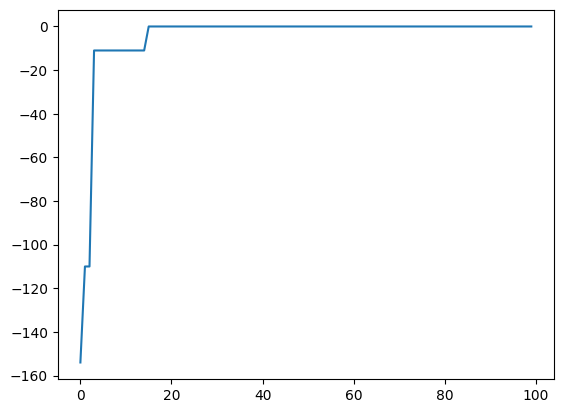

In [19]:
solution = gp.solve()

In [20]:
str(solution.code)

'(((x - 0) * (x - -2)) + (-2 + x))'